In [1]:
%pylab inline
from operator import itemgetter
import calin.math.hex_array
import calin.ix.iact_data.instrument_layout
import calin.io.sql_transceiver

Populating the interactive namespace from numpy and matplotlib


In [2]:
modchanmap = [ 3, 0, 6, 5, 4, 2, 1 ]
gridchanmap = [ 1, 6, 5, 0, 4, 3, 2 ]

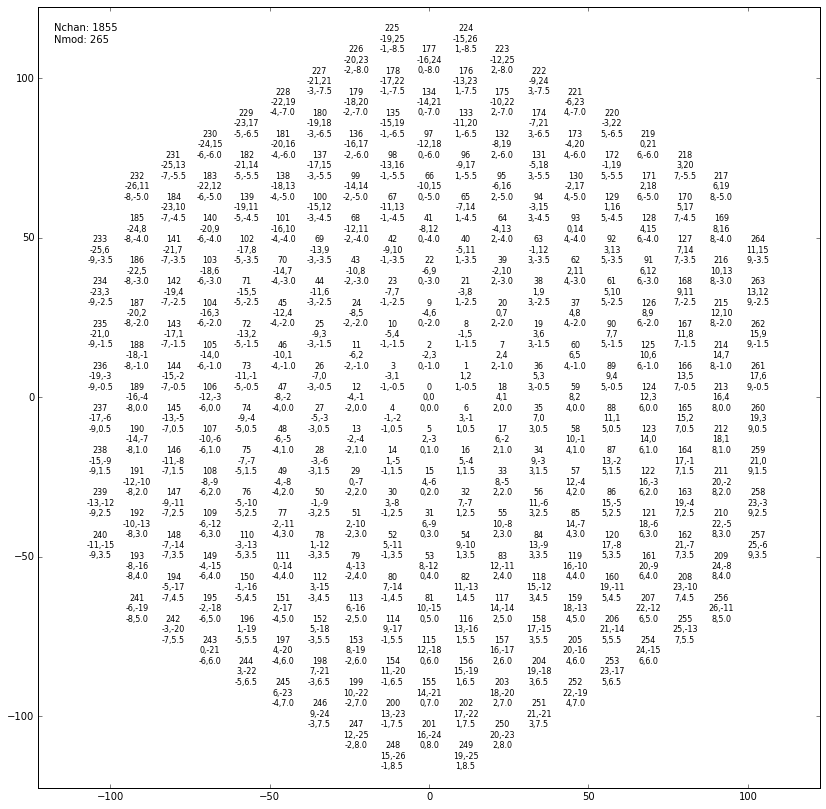

In [3]:
figure(figsize=[14,14])
spacing = 5
rad = 23.5*spacing
axis(asarray([-1,1,-1,1])*(rad+spacing))
nchan = 0
nmod = 0
u1,v1 = calin.math.hex_array.cluster_hexid_to_center_uv(1,1,False)
x1,y1 = calin.math.hex_array.uv_to_xy(u1,v1)
rot = arctan2(-y1,x1) + 30/180*pi
crot = cos(rot)
srot = sin(rot)
modvec = []
for i in range(0,calin.math.hex_array.ringid_to_nsites_contained(9)):
    uc,vc = calin.math.hex_array.cluster_hexid_to_center_uv(i,1,False)
    xc,yc = calin.math.hex_array.uv_to_xy_trans(uc,vc,crot,srot,spacing)
    if(xc*xc+yc*yc > rad*rad):
        continue
    mod = dict()
    mod['i'] = i
    mod['uc'] = uc
    mod['vc'] = vc
    mod['xc'] = xc
    mod['yc'] = yc
    mod['ix'] = (vc*2+uc*3)/7
    mod['iy'] = -(vc+uc)+2.5*mod['ix']
    modvec.append(mod)
    text(xc,yc,'%d\n%d,%d\n%d,%.1f'%(nmod,uc,vc,mod['ix'],mod['iy']),
         ha='center',va='center',fontsize=8)
    nchan=nchan+7
    nmod = nmod+1
#gca().add_patch(Circle((0,0),rad,color='r',fill=False))
text(-rad,rad,'Nchan: %d\nNmod: %d\n'%(nchan,nmod),va='top')

In [4]:
modvec.sort(key=itemgetter('ix', 'iy'))

In [5]:
grid_chan_index = dict()
for imod,mod in enumerate(modvec):
    mhid = calin.math.hex_array.cluster_hexid_to_member_hexid(mod['i'],1,False)
    for imodchan in range(0,len(mhid)):
        ichan = imod*7+imodchan
        igridchan = mhid[gridchanmap[imodchan]]
        grid_chan_index[igridchan] = ichan

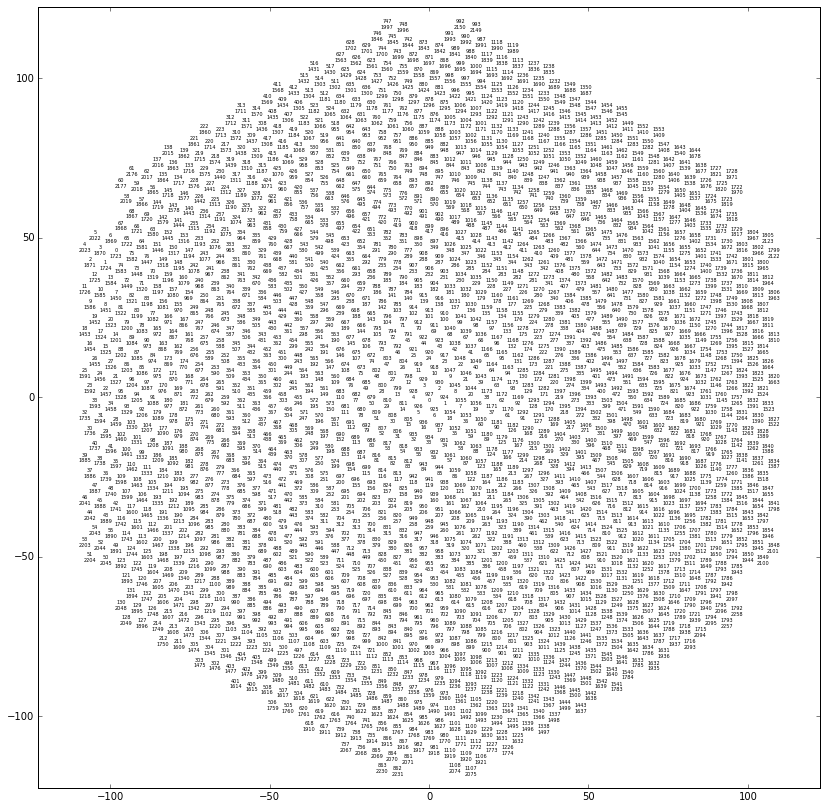

In [6]:
layout = calin.ix.iact_data.instrument_layout.CameraLayout()

layout.set_camera_type(layout.NECTARCAM);
#  repeated ChannelLayout channel                           = 10 [
layout.set_pixel_grid_layout(layout.HEX_GRID);
layout.set_pixel_grid_spacing(spacing);
layout.set_pixel_grid_rotation(rot/pi*180);
layout.set_pixel_grid_cos_rotation(cos(rot));
layout.set_pixel_grid_sin_rotation(sin(rot));
layout.set_pixel_grid_offset_x(0);
layout.set_pixel_grid_offset_y(0);
layout.set_pixel_grid_geometric_area(layout.pixel_grid_spacing()**2*sqrt(3)/2)
layout.set_channels_per_module(7)
#  ModuleLayout module                                      = 21 [
#    (CFO).desc = "Layout of each module." ];
layout.set_adc_gains(layout.PARALLEL_DUAL_GAIN)
layout.set_adc_bits(12)
layout.set_can_read_waveforms(True);
layout.set_can_read_charges(True);
layout.set_can_read_peak_sample(False);

figure(figsize=[14,14])
axis(asarray([-1,1,-1,1])*(rad+spacing))
chanvec = []
for imod,mod in enumerate(modvec):
    m = layout.add_module()
    mhid = calin.math.hex_array.cluster_hexid_to_member_hexid(mod['i'],1,False)
#    print(mhid)
    for imodchan in range(0,len(mhid)):
        ichan = imod*7+imodchan
        igridchan = mhid[gridchanmap[imodchan]]
        u,v = calin.math.hex_array.hexid_to_uv(igridchan)
        xc,yc = calin.math.hex_array.uv_to_xy_trans(u,v,crot,srot,spacing)
        m.add_channels_in_module(ichan)
        c = layout.add_channel()
        c.set_channel_index(ichan)
        c.set_pixel_index(ichan)
        c.set_pixel_grid_index(igridchan)
        c.set_channel_set_index(0)
        c.set_module_index(imod)
        c.set_module_channel_index(imodchan)
        c.set_x(xc)
        c.set_y(yc)
        c.set_diameter(layout.pixel_grid_spacing())
        c.set_geometric_area(layout.pixel_grid_geometric_area())
        neighbours = calin.math.hex_array.hexid_to_neighbor_hexids(igridchan)
        for nid in filter(lambda id: grid_chan_index.get(id), neighbours):
            c.add_neighbour_channel_indexes(grid_chan_index.get(nid))
        hold('on')
        text(xc,yc,'%d\n%d'%(ichan,igridchan),
             ha='center',va='center',fontsize=5)

In [7]:
sql = calin.io.sql_transceiver.SQLite3Transceiver("nectarcam.sqlite",
                  calin.io.sql_transceiver.SQLite3Transceiver.TRUNCATE_RW)
sql.create_tables("camera", layout.descriptor())
sql.insert("camera", layout)
sql = None

In [8]:
#print(layout.DebugString())

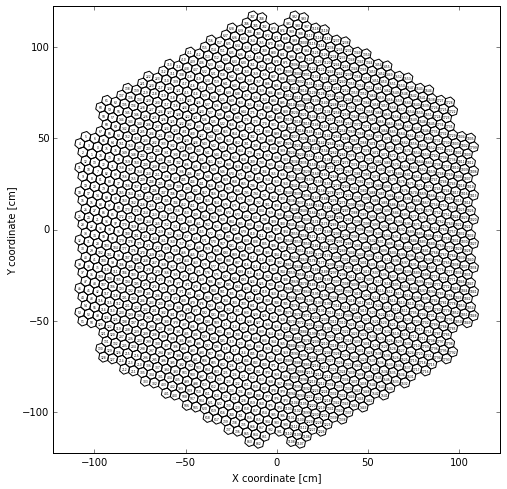

In [9]:
crot = cos(layout.pixel_grid_rotation()/180*pi)
srot = sin(layout.pixel_grid_rotation()/180*pi)
spacing = layout.pixel_grid_spacing()
figure(figsize=[8,8])
axis(asarray([-1,1,-1,1])*(rad+spacing))
for ii,ch in enumerate(layout.channel()):
    gid = ch.pixel_grid_index();
    u,v = calin.math.hex_array.hexid_to_uv(gid)
    x,y = calin.math.hex_array.uv_to_xy_trans(u,v,crot,srot,spacing)
    xv,yv = calin.math.hex_array.uv_to_vertexes_xy_trans(u,v,crot,srot,spacing)
    xyv = array([xv,yv])
    gca().add_patch(Polygon(xyv.transpose(),fill=False))
    text(x,y,'%d'%ii,ha='center',va='center',fontsize=3)
    hold('on')
xlabel('X coordinate [cm]')
ylabel('Y coordinate [cm]')
gcf().savefig('nectarcam.pdf')